<a href="https://colab.research.google.com/github/vishkaush/misc-projects/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat Classification Example

## Load data and pre-processing

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
import h5py

train_dataset = h5py.File('/content/drive/MyDrive/andrew_dl_data/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels
print("train_set_x_orig's shape = ", train_set_x_orig.shape)
print("train_set_y_orig's shape = ", train_set_y_orig.shape)

test_dataset = h5py.File('/content/drive/MyDrive/andrew_dl_data/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels
print("test_set_x_orig's shape = ", test_set_x_orig.shape)
print("test_set_y_orig's shape = ", test_set_y_orig.shape)

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
print("classes = ", classes)

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

train_set_x_orig's shape =  (209, 64, 64, 3)
train_set_y_orig's shape =  (209,)
test_set_x_orig's shape =  (50, 64, 64, 3)
test_set_y_orig's shape =  (50,)
classes =  [b'non-cat' b'cat']


Label of this image =  1  that is 'cat '


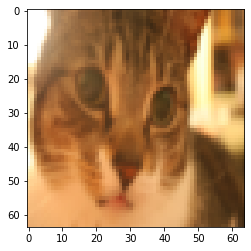

In [30]:
import matplotlib.pyplot as plt
index = 200
plt.imshow(train_set_x_orig[index])
print("Label of this image = ", train_set_y_orig[0, index], " that is '" + classes[train_set_y_orig[0, index]].decode("utf-8"), "'")

In [31]:
# Now we want to flatten the images to form train matrix of shape (64*64*3, 209)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [32]:
# one common pre-processing step is to do (x-\mu)/\sigma
# But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

train_set_X = train_set_x_flatten/255.
test_set_X = test_set_x_flatten/255.
assert(train_set_X.shape[0] == test_set_X.shape[0])
print("num_features = ", train_set_X.shape[0])
print("num_train = ", train_set_X.shape[1])
print("num_test = ", test_set_X.shape[1])

num_features =  12288
num_train =  209
num_test =  50


## Logistic Regression from First Principles

In [33]:
def sigmoid(x):
  s = 1/(1+np.exp(-x))
  return s

In [34]:
def forward_backward(w, b, X, y):
  num_features = X.shape[0]
  m = X.shape[1]  # number of training examples
  z = np.dot(w.T,X)+b   # does for all training examples to give (1, m)
  assert(z.shape == (1, m))
  a = sigmoid(z) # (1, m)
  assert(a.shape == (1, m))
  cost = -np.sum(y * np.log(a) + (1 - y) * np.log(1 - a)) / m
  dw = (1/m) * np.dot(X,((a-y).T)) # dw = (1/m)*np.dot(X, dz.T), dz = A - Y
  assert(dw.shape == (num_features, 1))
  db = sum((1/m) * sum(a-y))
  assert(db.dtype == float)
  grads = {"dw": dw,
           "db": db}
  return grads, cost

In [35]:
def train(X_train, y_train, num_iterations, learning_rate, X_test, y_test, accuracyEveryN=None):
  # initialize parameters
  num_features = X_train.shape[0]
  w = np.zeros((num_features, 1))  
  b = 0
  costs = []
  train_accuracies = []
  test_accuracies = []
  for i in range(num_iterations):
    grads, cost = forward_backward(w, b, X_train, y_train)
    dw = grads["dw"]
    db = grads["db"]
    #print("dw = ", dw)
    #print("db = ", db)
    #print("cost = ", cost)
    w = w-learning_rate*dw
    b = b-learning_rate*db
    costs.append(cost)
    if accuracyEveryN is not None and i%accuracyEveryN==0:
        y_prediction_test = predict(w, b, X_test)
        y_prediction_train = predict(w, b, X_train)
        train_accuracy = 100 - np.mean(np.abs(y_prediction_train - y_train)) * 100 
        test_accuracy = 100 - np.mean(np.abs(y_prediction_test - y_test)) * 100
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
  retVal = {"w": w,
            "b": b,
            "costs": costs,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "learning_rate": learning_rate}
  return retVal

In [36]:
def predict(w, b, X):
  m = X.shape[1]
  z = np.dot(w.T,X)+b
  assert(z.shape==(1, m))
  y = sigmoid(z)
  assert(y.shape==(1, m))
  y_prediction = np.where(y > 0.5, 1.0, 0.0)
  assert(y_prediction.shape==(1, m))
  return y_prediction

In [38]:
result = train(train_set_X, train_set_y_orig, 2000, 0.005, test_set_X, test_set_y_orig, 100)

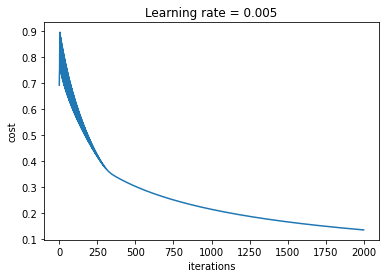

In [39]:
plt.plot(result["costs"])
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate = 0.005")
plt.show()

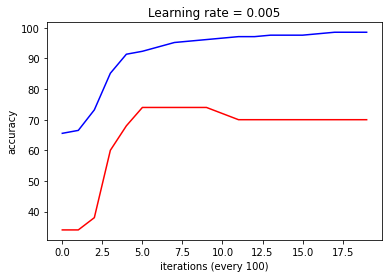

In [43]:
plt.plot(result["train_accuracies"], 'b')
plt.plot(result["test_accuracies"], 'r')
plt.ylabel('accuracy')
plt.xlabel('iterations (every 100)')
plt.title("Learning rate = 0.005")
plt.show()

## Effect of learning rate

learning rate is: 0.01

-------------------------------------------------------

learning rate is: 0.001

-------------------------------------------------------

learning rate is: 0.0001

-------------------------------------------------------



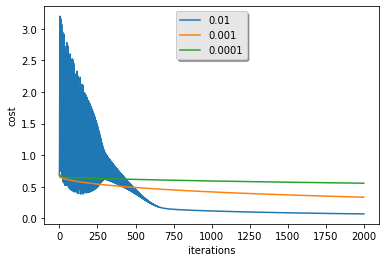

In [41]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = train(train_set_X, train_set_y_orig, 2000, i, test_set_X, test_set_y_orig, 100)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(models[str(i)]["costs"], label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

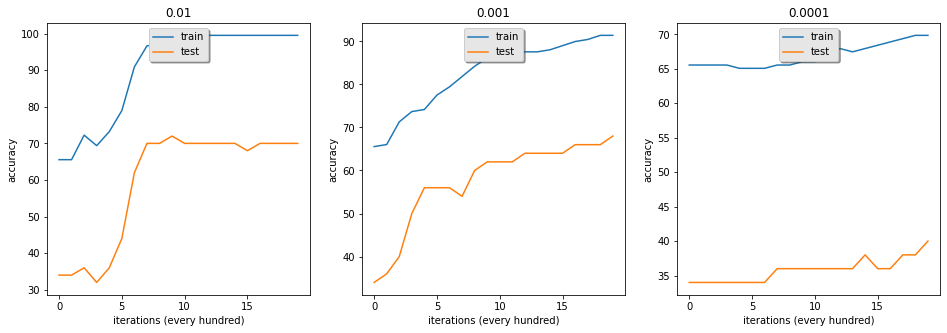

In [42]:
plt.figure(figsize = (16, 5))
index = 1
for i in learning_rates:
    plt.subplot(1,3,index)
    plt.plot(models[str(i)]["train_accuracies"], label= "train")
    plt.plot(models[str(i)]["test_accuracies"], label= "test")
    plt.title(str(models[str(i)]["learning_rate"]))
    plt.ylabel('accuracy')
    plt.xlabel('iterations (every hundred)')
    legend = plt.legend(loc='upper center', shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    index += 1